# ABC-SMC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [40]:
import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\background"

my_path = os.path.abspath(__file)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

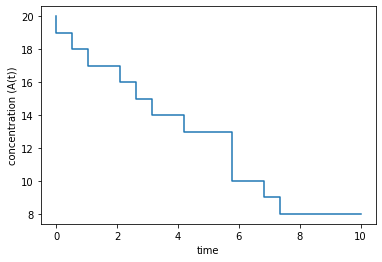

In [3]:
np.random.seed(2)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 20)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

## Fit using ABC SMC

The ABC SMC method can be used to perform parameter inference for stochastic models, where the likelihood is intractable. In ABC methods, typically, a distance metric comparing the observed data and the simulated is used. Here, we use the root mean square error (RMSE), and we accept a parameter value if the $RMSE<3$ for the first intermediate distribution, $RMSE<1.5$ for the second one and $RMSE<1$ for the last. The size of the intermediate distributions will be 200.

In [4]:
np.random.seed(0)

from math import comb

n_0 = 20

# Probability for one data point
def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

# Probability for multiple data points
def prob_gen(data, times, k):
    all_prob = 1.0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob *= computed_prob
    return all_prob


# Compute integral
from scipy import integrate

func = lambda x : prob_gen(values, times, x)
int_val = integrate.quad(func, 0.01, 0.3)
print("likelihood integrate value="+str(int_val[0]))

# True posterior
def posterior(data, times, k):
    return prob_gen(data, times, k) / int_val[0]

thetas = np.linspace(0.01, 0.3, 200)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(posterior(values, times, thetas[i]))

v_func = lambda x : posterior(values, times, x)
i_val = integrate.quad(v_func, 0.01, 0.3)

print("posterior integrate value="+str(i_val[0]))

likelihood integrate value=5.086995413811021e-16
posterior integrate value=0.9999392938746746


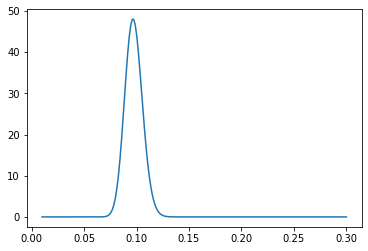

In [5]:
plt.plot(thetas, true_prob)
plt.show()

In [35]:
np.random.seed(0)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([10,5,1]))

# set perturbation kernel

abc.sampler().set_perturbation_kernel(pints.UniformLogPrior([0.0], [0.2]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(3000)

# log to screen
abc.set_log_interval(20)
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.0
2     2      1                0:00.0
3     3      1                0:00.0
20    20     1                0:00.0
40    40     1                0:00.0
60    60     1                0:00.0
80    80     1                0:00.1
100   100    1                0:00.1
120   120    1                0:00.1
140   140    1                0:00.1
160   160    1                0:00.1
180   180    1                0:00.1
200   200    1                0:00.1
220   220    1                0:00.1
240   240    1                0:00.2
260   260    1                0:00.2
280   280    1                0:00.2
300   300    1                0:00.2
320   320    1                0:00.2
340   340    1                0:00.2
360   360    1                0:00.2
380   380    1                0:00.2
400   400    1                0:00.2
420   420    1             

In [36]:
fst_gen_samples = [x[0] for x in samples[:1000]]
snd_gen_samples = [x[0] for x in samples[1000:2000]]
trd_gen_samples = [x[0] for x in samples[2000:]]

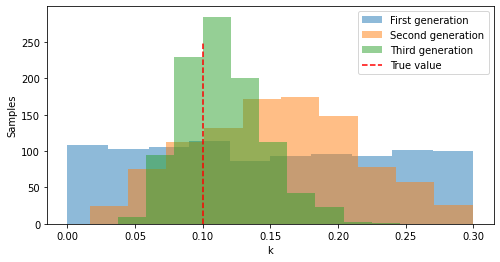

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plt.hist(fst_gen_samples, bins=10, label='First generation', alpha=0.5)
plt.hist(snd_gen_samples, bins=10, label='Second generation', alpha=0.5)
plt.hist(trd_gen_samples, bins=10, label='Third generation', alpha=0.5)

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=250, label='True value', color='red')
plt.legend()
# plt.show()
plt.xlabel("k")
plt.ylabel("Samples")
plt.savefig(my_path + './pmc_hist.pdf')

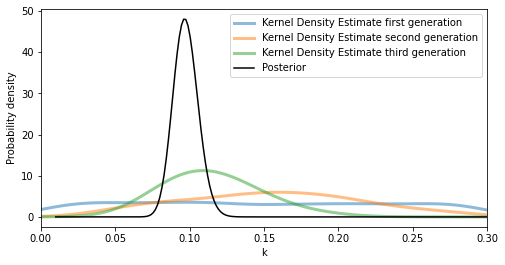

In [55]:

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(np.array(fst_gen_samples), x_grid, bandwidth=0.02),
            label='Kernel Density Estimate first generation', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(snd_gen_samples), x_grid, bandwidth=0.02),
            label='Kernel Density Estimate second generation', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(trd_gen_samples), x_grid, bandwidth=0.02),
            label='Kernel Density Estimate third generation', linewidth=3, alpha=0.5)
ax.plot(thetas, true_prob, color="black", label="Posterior")
ax.set_xlim(0, 0.3)
plt.xlabel("k")
plt.ylabel("Probability density")
ax.legend()
# plt.show()
plt.savefig(my_path + './pmc_kde.pdf')

In [48]:
def kl_func(y, post, kde_skl):
    part = posterior(values, times, y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div(x, bandwidth, posterior, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func(y, posterior, kde_skl)
    return integrate.quad(fun, 0.01, 0.3)

def s_posterior(theta):
    return posterior(values, times, theta)


kl_fst_gen = kl_div(np.array(fst_gen_samples), 0.02, s_posterior)[0]
kl_snd_gen = kl_div(np.array(snd_gen_samples), 0.02, s_posterior)[0]
kl_trd_gen = kl_div(np.array(trd_gen_samples), 0.02, s_posterior)[0]

print("kl first gen = " + str(kl_fst_gen))
print("kl second gen = " + str(kl_snd_gen))
print("kl third gen = " + str(kl_trd_gen))

kl first gen = 2.109296250007663
kl second gen = 1.9439647547971035
kl third gen = 1.0395808941624949
